**A Books Recommender System**

This recommender system will seek to model a user’s behavior regarding the ratings they give to different books. It will then be able to recommend similar books to the user and also to similar users.

**Types of Recommender Systems**

**Collaborative Filtering Systems**: These types of recommender systems are based on the user’s direct behavior. That is, this system builds a model of the user based on past choices, activities, and preferences. It then uses this knowledge to predict what the user will like based on their similarity to other user profiles.

**Content-Based Filtering System**: Content-based recommender systems, on the other hand, are based on the items, and not necessarily the users. This method builds an understanding of similarity between items. That is, it recommends items that are similar to each other in terms of properties.

In this assignment, I have used an embedding to build a profile/understanding of the interactions between users and books.

**The Data**

The dataset I used contains ten thousand books and one million ratings given by users.

The ratings dataset contains just three columns: book_id, user_id, and the corresponding rating given by the user.

The book dataset has 23 columns and contains different metadata about the books, eg book title, book author, ISBN number, book image, and so on. This is the data used when making predictions, and also when we’re displaying the books to users in our application.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [2]:
ratings_df = pd.read_csv("https://raw.githubusercontent.com/Engineersticity/classwork-DM/master/ratings.csv") 
books_df = pd.read_csv("https://raw.githubusercontent.com/Engineersticity/classwork-DM/master/books.csv")
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [3]:
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
ratings_df.isna().sum()

(981756, 3)
53424
10000


book_id    0
user_id    0
rating     0
dtype: int64

There are 981756 ratings given by 53,424 users to 10,000 books. That means different users have rated multiple books, and each book has been rated by more than one user.

Split the data into train and test sets so as to effectively evaluate the model performance

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


Create a neural network with two input embedding layers. The first embedding layer accepts the books, and the second the users. These two embeddings are trained separately and then combined together before being passed to a dense layer.

In [6]:
# First get the number of unique entities in books and users columns. This forms the vocabulary for the embeddings.
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()
print(nbook_id, nuser_id)

10000 53424


In [7]:
#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

Now that the network has been defined, it is compiled by choosing an optimizer and a loss function. I decided to use an Adam optimizer here with a learning rate of 0.001, and mean squared error as the loss function.

In [8]:
# opt = keras.optimizers.Adam(learning_rate=0.01)

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
# model.compile(loss='categorical_crossentropy', optimizer=opt)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

Next, the model is fitted, evaluated and plotted to see how well it is doing

In [9]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/5
12272/12272 [==============================] - 169s 14ms/step - loss: 1.3459 - val_loss: 0.7136
Epoch 2/5
12272/12272 [==============================] - 168s 14ms/step - loss: 0.6768 - val_loss: 0.6984
Epoch 3/5
12272/12272 [==============================] - 171s 14ms/step - loss: 0.6365 - val_loss: 0.6958
Epoch 4/5
12272/12272 [==============================] - 174s 14ms/step - loss: 0.6069 - val_loss: 0.7156
Epoch 5/5
12272/12272 [==============================] - 176s 14ms/step - loss: 0.5771 - val_loss: 0.7013


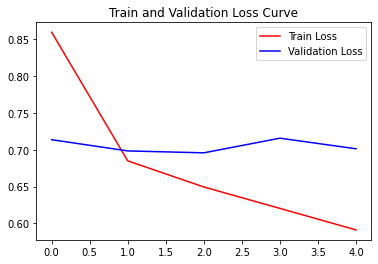

In [10]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [11]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [12]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]

In [13]:
book_em_weights.shape

(10001, 15)

In [14]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")
books_df_copy.head(2)

,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
book_id,,,,,,,,,,,,,,,,,,,,,,
2767052,1,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
3,2,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [15]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)

In [16]:
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')

for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

In [17]:
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[4.2370677],
       [4.3490524],
       [3.001546 ],
       ...,
       [4.349995 ],
       [4.2017517],
       [3.660042 ]], dtype=float32)

In [18]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:10]
pred_ids

array([7946, 7253, 6589, 5206, 8108, 9841, 3752, 3627, 1787, 9565])

In [19]:
books_df.iloc[pred_ids]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
7946,7947,5031805,5031805,40769318,96,1433502410,9.781434e+12,"Anonymous, Lane T. Dennis, Wayne A. Grudem",2002.0,NaN,ESV Study Bible,eng,4.76,8953,10784,262,98,90,367,1152,9077,https://images.gr-assets.com/books/1410151002m...,https://images.gr-assets.com/books/1410151002s...
7253,7254,24816,24816,2369970,23,836217691,9.780836e+12,Bill Watterson,1994.0,Homicidal Psycho Jungle Cat: A Calvin and Hobb...,Homicidal Psycho Jungle Cat: A Calvin and Hobb...,eng,4.71,14113,15729,289,13,53,696,2900,12067,https://images.gr-assets.com/books/1448818381m...,https://images.gr-assets.com/books/1448818381s...
6589,6590,59715,59715,1010526,21,751507954,9.780752e+12,Bill Watterson,1990.0,The Authoritative Calvin and Hobbes,The Authoritative Calvin and Hobbes: A Calvin ...,eng,4.73,16087,18198,425,20,61,701,3295,14121,https://images.gr-assets.com/books/1391114055m...,https://images.gr-assets.com/books/1391114055s...
5206,5207,24818,24818,946589,28,836217357,9.780836e+12,Bill Watterson,1993.0,The Days Are Just Packed: A Calvin and Hobbes ...,The Days Are Just Packed: A Calvin and Hobbes ...,en-US,4.68,19143,20374,228,114,149,942,3636,15533,https://images.gr-assets.com/books/1418211162m...,https://images.gr-assets.com/books/1418211162s...
8108,8109,23753,23753,1789924,5,1401210821,9.781401e+12,"Neil Gaiman, Mike Dringenberg, Chris Bachalo, ...",2006.0,"The Absolute Sandman, Volume One","The Absolute Sandman, Volume One",eng,4.65,13401,13726,476,72,128,684,2744,10098,https://images.gr-assets.com/books/1312226853m...,https://images.gr-assets.com/books/1312226853s...
9841,9842,24019187,24019187,43618137,12,1250058902,9.781250e+12,Brandon Stanton,2015.0,Humans of New York: Stories,Humans of New York: Stories,eng,4.50,12527,12852,1210,191,211,901,3231,8318,https://images.gr-assets.com/books/1430176879m...,https://images.gr-assets.com/books/1430176879s...
3752,3753,10,10,21457570,6,439827604,9.780440e+12,J.K. Rowling,2005.0,"Harry Potter Collection (Harry Potter, #1-6)","Harry Potter Collection (Harry Potter, #1-6)",eng,4.73,24618,26274,882,203,186,946,3891,21048,https://images.gr-assets.com/books/1328867351m...,https://images.gr-assets.com/books/1328867351s...
3627,3628,24812,24812,25599,14,740748475,9.780741e+12,Bill Watterson,2005.0,The Complete Calvin and Hobbes,The Complete Calvin and Hobbes,eng,4.82,28900,29968,861,120,154,693,3117,25884,https://images.gr-assets.com/books/1473064526m...,https://images.gr-assets.com/books/1473064526s...
1787,1788,24813,24813,692719,17,836204387,9.780836e+12,Bill Watterson,1995.0,The Calvin and Hobbes Tenth Anniversary Book,The Calvin and Hobbes Tenth Anniversary Book,eng,4.63,48280,48829,346,346,608,3077,8752,36046,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9565,9566,70487,70487,2244439,24,1417642165,9.781418e+12,Bill Watterson,1992.0,Attack of the Deranged Mutant Killer Monster S...,Attack of the Deranged Mutant Killer Monster S...,eng,4.72,9713,12197,233,15,30,514,2292,9346,https://images.gr-assets.com/books/1384735429m...,https://images.gr-assets.com/books/1384735429s...


In [23]:
web_book_data = books_df[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

,book_id,title,image_url,authors
26,1,Harry Potter and the Half-Blood Prince (Harry ...,https://images.gr-assets.com/books/1361039191m...,"J.K. Rowling, Mary GrandPré"
20,2,Harry Potter and the Order of the Phoenix (Har...,https://images.gr-assets.com/books/1387141547m...,"J.K. Rowling, Mary GrandPré"
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
17,5,Harry Potter and the Prisoner of Azkaban (Harr...,https://images.gr-assets.com/books/1499277281m...,"J.K. Rowling, Mary GrandPré, Rufus Beck"
23,6,Harry Potter and the Goblet of Fire (Harry Pot...,https://images.gr-assets.com/books/1361482611m...,"J.K. Rowling, Mary GrandPré"


In [21]:
web_book_data.to_json(r'web_book_data.json', orient='records')